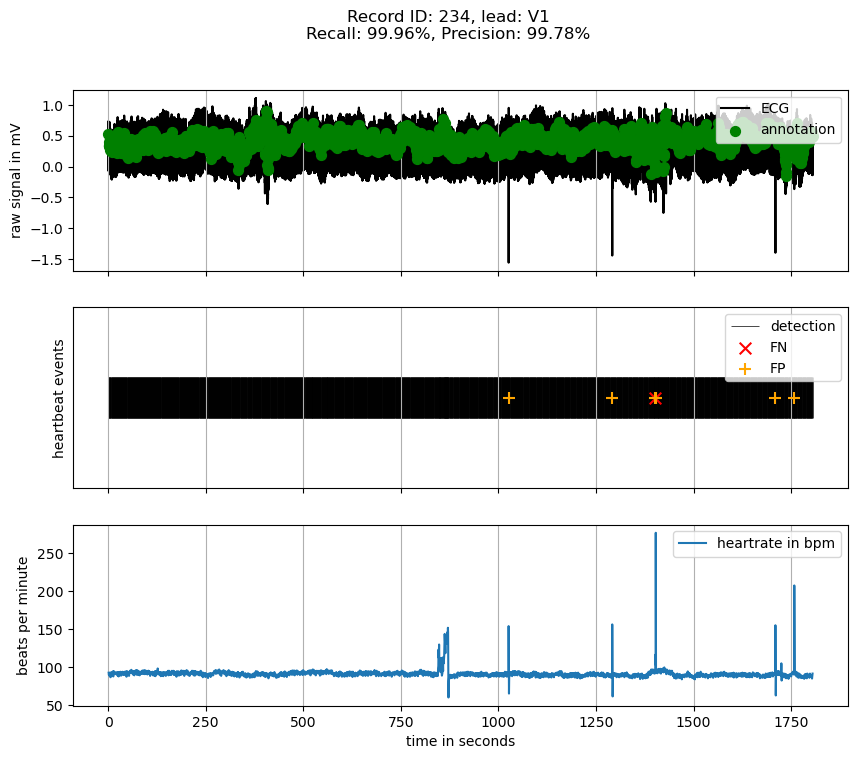

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sleepecg import compare_heartbeats, detect_heartbeats, read_mitdb

# download and read data
record = list(read_mitdb(records_pattern="234"))[1]

# detect heartbeats
detection = detect_heartbeats(record.ecg, record.fs)

# evaluation and visualization
TP, FP, FN = compare_heartbeats(detection, record.annotation,
                                int(record.fs / 10))

t = np.arange(len(record.ecg)) / record.fs

fig, ax = plt.subplots(3, sharex=True, figsize=(10, 8))

ax[0].plot(t, record.ecg, color="k", zorder=1, label="ECG")
ax[0].scatter(
    record.annotation / record.fs,
    record.ecg[record.annotation],
    marker="o",
    color="g",
    s=50,
    zorder=2,
    label="annotation",
)
ax[0].set_ylabel("raw signal in mV")

ax[1].eventplot(
    detection / record.fs,
    linelength=0.5,
    linewidth=0.5,
    color="k",
    zorder=1,
    label="detection",
)
ax[1].scatter(
    FN / record.fs,
    np.ones_like(FN),
    marker="x",
    color="r",
    s=70,
    zorder=2,
    label="FN",
)
ax[1].scatter(
    FP / record.fs,
    np.ones_like(FP),
    marker="+",
    color="orange",
    s=70,
    zorder=2,
    label="FP",
)
ax[1].set_yticks([])
ax[1].set_ylabel("heartbeat events")

ax[2].plot(
    detection[1:] / record.fs,
    60 / (np.diff(detection) / record.fs),
    label="heartrate in bpm",
)
ax[2].set_ylabel("beats per minute")
ax[2].set_xlabel("time in seconds")

for ax_ in ax.flat:
    ax_.legend(loc="upper right")
    ax_.grid(axis="x")

fig.suptitle(
    f"Record ID: {record.id}, lead: {record.lead}\n" +
    f"Recall: {len(TP) / (len(TP) + len(FN)):.2%}, " +
    f"Precision: {len(TP) / (len(TP) + len(FP)):.2%}", )

plt.show()

c:\Users\admin\.conda\envs\lzw\Lib\site-packages\sleepecg\feature_extraction.py:505: RuntimeWarning: HR analysis window too short for estimating PSD for feature VLF. 3030.3s required, got 270s
  warnings.warn(msg, category=RuntimeWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(<Figure size 700x400 with 2 Axes>,
 array([<Axes: ylabel='predicted'>,
        <Axes: xlabel='time of day in hours', ylabel='probabilities'>],
       dtype=object))

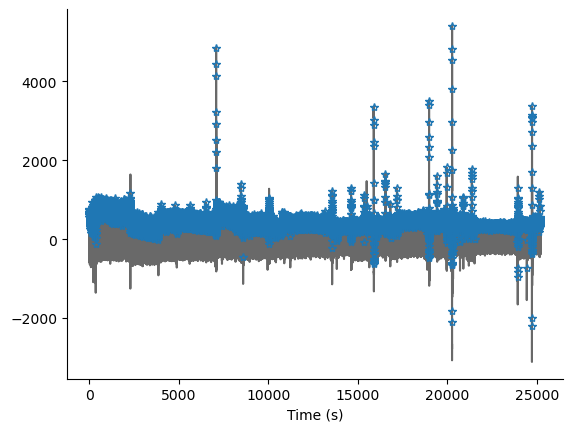

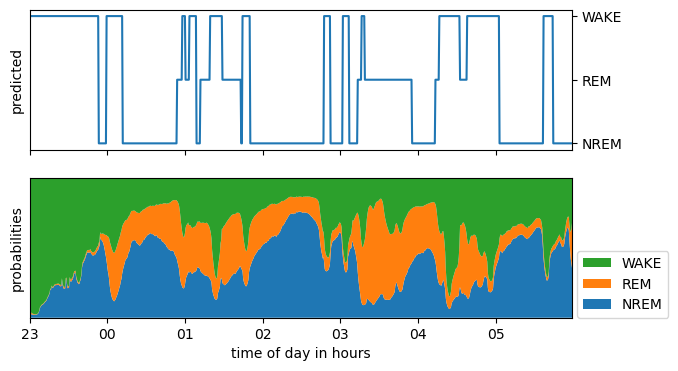

In [2]:
from datetime import datetime

from edfio import read_edf

import sleepecg

# load dataset
edf = read_edf("sleep.edf")

# crop dataset (we only want data for the sleep duration)
start = datetime(2023, 3, 1, 23, 0, 0)
stop = datetime(2023, 3, 2, 6, 0, 0)
rec_start = datetime.combine(edf.startdate, edf.starttime)
edf.slice_between_seconds((start - rec_start).seconds,
                          (stop - rec_start).seconds)

# get ECG time series and sampling frequency
ecg = edf.get_signal("ECG").data
fs = edf.get_signal("ECG").sampling_frequency

# detect heartbeats
beats = sleepecg.detect_heartbeats(ecg, fs)
sleepecg.plot_ecg(ecg, fs, beats=beats)

# load SleepECG classifier (requires tensorflow)
clf = sleepecg.load_classifier("wrn-gru-mesa-weighted", "SleepECG")

# predict sleep stages
record = sleepecg.SleepRecord(
    sleep_stage_duration=30,
    recording_start_time=start,
    heartbeat_times=beats / fs,
)

stages = sleepecg.stage(clf, record, return_mode="prob")

sleepecg.plot_hypnogram(
    record,
    stages,
    stages_mode=clf.stages_mode,
    merge_annotations=True,
)



In [3]:
import numpy as np

from sleepecg import SleepRecord, extract_features

# generate dummy data
recording_hours = 8
heartbeat_times = np.cumsum(np.random.uniform(0.5, 1.5,
                                              recording_hours * 3600))
sleep_stages = np.random.randint(1, 6, int(max(heartbeat_times)) // 30)
sleep_stage_duration = 30

record = SleepRecord(
    sleep_stages=sleep_stages,
    sleep_stage_duration=sleep_stage_duration,
    heartbeat_times=heartbeat_times,
)

features, stages, feature_ids = extract_features(
    [record],
    lookback=240,
    lookforward=60,
    feature_selection=["hrv-time", "LF_norm", "HF_norm", "LF_HF_ratio"],
)
X = features[0]

c:\Users\admin\.conda\envs\lzw\Lib\site-packages\sleepecg\feature_extraction.py:505: RuntimeWarning: HR analysis window too short for estimating PSD for feature VLF. 3030.3s required, got 270s
  warnings.warn(msg, category=RuntimeWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


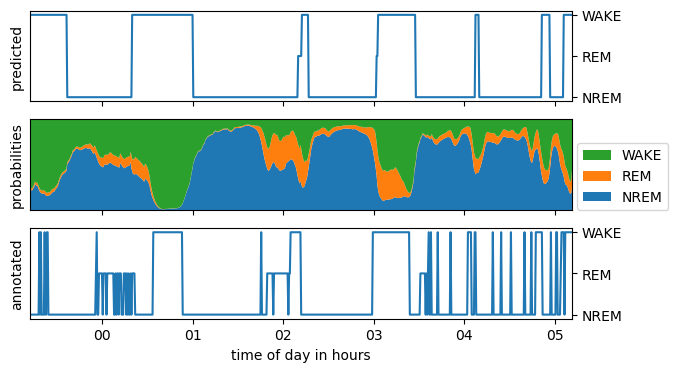

In [4]:
import matplotlib.pyplot as plt

from sleepecg import load_classifier, plot_hypnogram, read_slpdb, stage

# the model was built with tensorflow 2.16.1, running on higher versions might create
# warnings, but should not influence the results
clf = load_classifier("wrn-gru-mesa", "SleepECG")

# load record
rec = next(read_slpdb("slp03"))

# predict stages and plot hypnogram
stages_pred = stage(clf, rec, return_mode="prob")

plot_hypnogram(
    rec,
    stages_pred,
    stages_mode=clf.stages_mode,
    merge_annotations=True,
)

plt.show()

c:\Users\admin\.conda\envs\lzw\Lib\site-packages\sleepecg\feature_extraction.py:505: RuntimeWarning: HR analysis window too short for estimating PSD for feature VLF. 3030.3s required, got 270s
  warnings.warn(msg, category=RuntimeWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


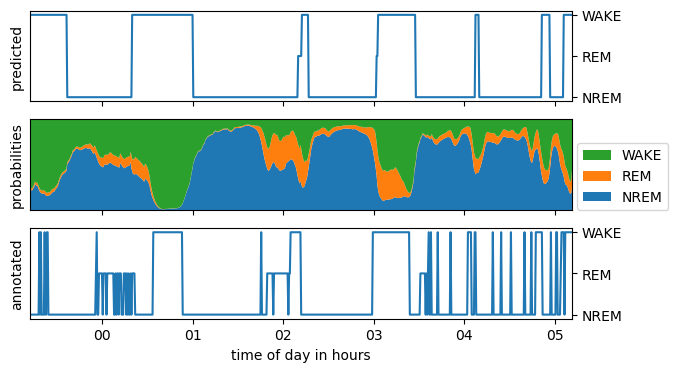

In [5]:
import matplotlib.pyplot as plt

from sleepecg import load_classifier, plot_hypnogram, read_slpdb, stage

clf = load_classifier("wrn-gru-mesa", "SleepECG")

rec = next(read_slpdb("slp03"))

stages_pred = stage(clf, rec, return_mode="prob")

plot_hypnogram(
    rec,
    stages_pred,
    stages_mode=clf.stages_mode,
    merge_annotations=True,
)

plt.show()

c:\Users\admin\.conda\envs\lzw\Lib\site-packages\sleepecg\feature_extraction.py:505: RuntimeWarning: HR analysis window too short for estimating PSD for feature VLF. 3030.3s required, got 270s
  warnings.warn(msg, category=RuntimeWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


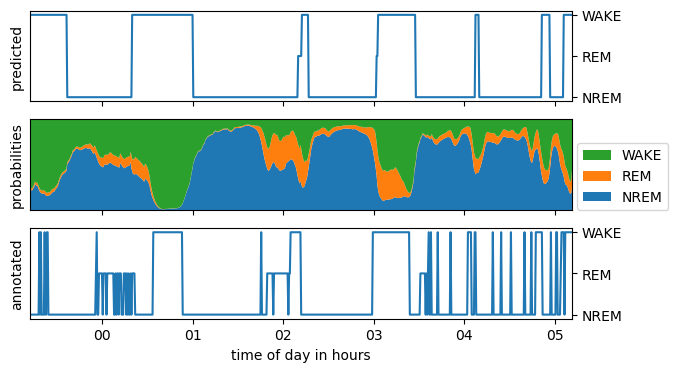

In [6]:
import matplotlib.pyplot as plt

from sleepecg import load_classifier, plot_hypnogram, read_slpdb, stage

# the model was built with tensorflow 2.16.1, running on higher versions might create
# warnings, but should not influence the results
clf = load_classifier("wrn-gru-mesa", "C:/Users/admin/Desktop/kaifa/sleepStage")

# load record
rec = next(read_slpdb("slp03"))

# predict stages and plot hypnogram
stages_pred = stage(clf, rec, return_mode="prob")

plot_hypnogram(
    rec,
    stages_pred,
    stages_mode=clf.stages_mode,
    merge_annotations=True,
)

plt.show()